# Formalia:

Please read the [assignment overview page](https://github.com/lalessan/comsocsci2021/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Tuesday, April 6th at 23:55. Hand in your Jupyter notebook file (with extension `.ipynb`) via DTU Learn _(Course Content, Assignemnts, Assignment 2)_

## Part 1: Properties of the real-world network of Redditors


For this Exercise you need the network of redditors you built in Week3, Part 3. Feel free to upload it from file or compute it in the notebook.

> _Exercise_
> 2.1 _Random Network_: In this exercise we will create a Random Network as a null model to investigate some properties of the Redditors Network.
> * Compute the value of _p_ such that the number of expected edges of the random network equals the number of edges in the redditor network (see equation 3.2 in your Network Science Book). What is the value of p? Compute the average value of the degree < k > (using the formula).
> * Use NetworkX to create a Random network with the same number of nodes as the redditor networks, and _p_ as computed above. You can use the function [``erdos_renyi_graph``](https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.erdos_renyi_graph.html#networkx.generators.random_graphs.erdos_renyi_graph) in NetworkX. 
>
>
> 2.2 _Degree Distribution_: In this exercise, we will compare the degree distribution of the real network and its random counterpart.
> * Compute the distribution of degree for the random network using the numpy function ``np.histogram``. Bin your histogram using 10 linearly spaced bins. Remember to pass the parameter ``density=True``.
> * Compute the distribution of degree for the Redditors undirected network using the numpy function ``np.histogram``. Bin your histogram using 10 logarithmically spaced bins. Remember to pass the parameter ``density=True``.
> * Plot the two distributions you computed in steps 1. and 2. in the same figure as two line-graphs. Log-scale the x and y axes. 
> * Comment the figure. What are the differences between the two distributions? Why did I ask you to use two different types of binning? 
> * What is the average degree of the random and the real network? Comment on the relation between the two. 
>
> 2.3 _Shortest Paths_: Here, we will check if the Redditors Network is a small-world Network.
> * Compute the average shortest path for the largest connected component of the Redditors network (for a reminder of the definition of connected components, check [section 2.9 of the Network Science book](http://networksciencebook.com/chapter/2#connectedness)). You can use the following steps: 
>    * Use [``nx.algorithms.connected_components``](https://networkx.org/documentation/stable//reference/algorithms/generated/networkx.algorithms.components.connected_components.html) to find all connected components (it returns a list of subsets of the original set of nodes). 
>    * Consider the largest subset of nodes found in the step above. Build the subgraph of your original network containing those nodes exclusively, using [``nx.Graph.subgraph``](https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.subgraph.html). This corresponds to your largest connected component (a.k.a [giant component](https://en.wikipedia.org/wiki/Giant_component)).
> * Compute the average shortest path length of the giant component using [``nx.average_shortest_path_length``](https://networkx.org/documentation/networkx-1.3/reference/generated/networkx.average_shortest_path_length.html)
> * Compute the average shortest path length for the giant component of the random network you built in exercise 2.1.
> * Comment on the relation between the average shortest path length in the real and the random networks. Can you conclude that the small-world property apply to the Redditors network? 
>
> 2.4 _Clustering_: Here, we will compare the clustering coefficient in the Redditors Network and its random counterpart.
> * Compute the clustering coefficient for all nodes in the random network, using networkx [``clustering``](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.cluster.clustering.html#networkx.algorithms.cluster.clustering) function. Compute the average across nodes. Is it consistent with the analytical prediction (network science book equation 3.21)?
> * Compute the average clustering coefficient for the Redditors network. How does it compare to its random counterpart? Is it something you would expect? Why?


In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import datetime as dt
from tqdm import tqdm
import networkx as nx
from pelutils import Table

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
mpl.rc("font", size=18)
mpl.rcParams["font.family"] = "Liberation Serif"

import nltk
from nltk.corpus import stopwords
import re
from tqdm import tqdm

import requests
import pandas as pd
import json
from collections import Counter
import wordcloud as wc

import netwulf as nw
import random
import pandas_datareader as pdr
import community as cm

In [2]:
# Build redditor network using data from exercizes
comments_df = pd.read_pickle("comments.pkl")
subs_df = pd.read_pickle("posts.pkl")
comment_authors = dict(zip(comments_df["id"], comments_df["author"]))
parent = dict(zip(comments_df["id"], comments_df["parent_id"]))
submission_authors = dict(zip(subs_df["id"], subs_df["author"]))

def parent_author(comment_id: str) -> str:
    parent_id = parent[comment_id]
    if parent_id.startswith("t1_"):
        return comment_authors.get(parent_id[3:])
    elif parent_id.startswith("t3_"):
        return submission_authors.get(parent_id[3:])
    raise KeyError(comment_id, parent_id)

comments_df["parent_author"] = [parent_author(cid) for cid in comments_df["id"]]
try:  # Try/except in case this cell has already been run
    comments_df = comments_df.set_index("created_utc")
except:
    pass
comments_df = comments_df[comments_df.index<dt.datetime(2020, 12, 31)]
comments_df = comments_df[comments_df.parent_author!="[deleted]"]
g = nx.DiGraph()
edges = comments_df.groupby(["author", "parent_author"], as_index=False).count()
g.add_weighted_edges_from([(a, p, n) for a, p, n in zip(edges.author, edges.parent_author, edges.parent_id)])

reddit = g.to_undirected(reciprocal=True)
for u, v, d in reddit.edges(data=True):
    d["weight"] = g.edges[u, v]["weight"] + g.edges[v, u]["weight"]
reddit.remove_edges_from(nx.selfloop_edges(reddit))
reddit.remove_nodes_from([n for n in reddit if reddit.degree(n) == 0])

> 2.1 _Random Network_: In this exercise we will create a Random Network as a null model to investigate some properties of the Redditors Network.
> * Compute the value of _p_ such that the number of expected edges of the random network equals the number of edges in the redditor network (see equation 3.2 in your Network Science Book). What is the value of p? Compute the average value of the degree < k > (using the formula).

In [3]:
N = len(reddit.nodes)
p = 2 * len(reddit.edges) / (N * (N-1))  # Eq. 3.2
k_avg = p * (N-1)  # Eq. 3.3
print("p = %.6f\nk = %.6f" % (p, k_avg))

p = 0.000292
k = 2.991718


> * Use NetworkX to create a Random network with the same number of nodes as the redditor networks, and _p_ as computed above. You can use the function [``erdos_renyi_graph``](https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.erdos_renyi_graph.html#networkx.generators.random_graphs.erdos_renyi_graph) in NetworkX. 

In [4]:
random = nx.erdos_renyi_graph(n=N, p=p)
# To make sure that N and p are correctly calculated, g should have the same number of nodes as ug and roughly the same number of edges
t = Table()
t.add_header(["Comparison of random and redditor graph", "Nodes", "Edges"])
t.add_row(["Random graph", len(random.nodes), len(random.edges)])
t.add_row(["Redditor graph", len(reddit.nodes), len(reddit.edges)])
print(t)

Comparison of random and redditor graph | Nodes | Edges
----------------------------------------+-------+------
Random graph                            | 10263 | 15228
Redditor graph                          | 10263 | 15352


> 2.2 _Degree Distribution_: In this exercise, we will compare the degree distribution of the real network and its random counterpart.
> * Compute the distribution of degree for the random network using the numpy function ``np.histogram``. Bin your histogram using 10 linearly spaced bins. Remember to pass the parameter ``density=True``.

In [5]:
def bins(data, spacing=lambda x, b: np.linspace(0, max(x), b), bins=10):
    bins = spacing(data, bins+1)
    hist, edges = np.histogram(data, bins=bins, density=True)
    x = (edges[1:] + edges[:-1]) / 2
    xx, yy = x[hist>0], hist[hist>0]
    return xx, yy

In [6]:
edges = [x[1] for x in random.degree()]
# Random network distribution
connections, dens = bins(edges)

> * Compute the distribution of degree for the Redditors undirected network using the numpy function ``np.histogram``. Bin your histogram using 10 logarithmically spaced bins. Remember to pass the parameter ``density=True``.

In [7]:
# Redditor network distribution
redges = [x[1] for x in reddit.degree()]
rconnections, rdens = bins(redges, lambda x, b: np.logspace(-1, np.log10(max(x)), b))

> * Plot the two distributions you computed in steps 1. and 2. in the same figure as two line-graphs. Log-scale the x and y axes.

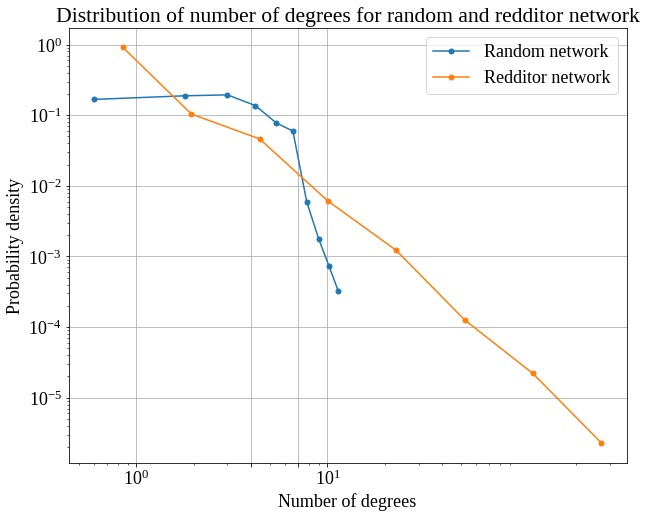

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(connections, dens, marker=".", ms=10, label="Random network")
ax.plot(rconnections, rdens, marker=".", ms=10, label="Redditor network")
ax.grid(True)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title("Distribution of number of degrees for random and redditor network")
ax.set_xlabel("Number of degrees")
ax.set_ylabel("Probability density")
ax.set_xticks(range(1, 11, 3))
ax.legend()

> * Comment the figure. What are the differences between the two distributions? Why did I ask you to use two different types of binning? 

The two figures closely follow the exptected distributions. The distribution for the (large) random network follows a Poisson distribution (NS, chapter 3.4).

The random network clearly underestimates the number of both low and high degree nodes. This is due to real networks often being much more clustered. This is in line with similar observations (NS, Image 3.6). This also explains why different binnings are necessary: The real network has many more high-degree nodes, making logarithmic binning desirable. Linear binning would clump all low and mid-degree nodes together, making the plot less informative and harder to read. On the other hand, the degrees for the random networks are more evenly distributed, making linear binning preferable.

> * What is the average degree of the random and the real network? Comment on the relation between the two. 

In [9]:
# Average degree for random network calculated earlier using eq. 3.3
# Average degree using eq. 2.2
k_avg = 2 * len(random.edges) / len(random.nodes)  # Random network
rk_avg = 2 * len(reddit.edges) / len(reddit.nodes)  # Redditor network
print("Average degree for random network:   %.6f" % k_avg)
print("Average degree for redditor network: %.6f" % rk_avg)

Average degree for random network:   2.967553
Average degree for redditor network: 2.991718


It is not surprising that the two are almost the same. The random network is generated such that probability of any possible edge existing is the same as in the redditor network. Thus the number of edges is expected to be close (within a few standard deviations). By equation 2.2, the average degrees should then also be nearly the same.

> 2.3 _Shortest Paths_: Here, we will check if the Redditors Network is a small-world Network.
> * Compute the average shortest path for the largest connected component of the Redditors network (for a reminder of the definition of connected components, check [section 2.9 of the Network Science book](http://networksciencebook.com/chapter/2#connectedness)). You can use the following steps: 
>    * Use [``nx.algorithms.connected_components``](https://networkx.org/documentation/stable//reference/algorithms/generated/networkx.algorithms.components.connected_components.html) to find all connected components (it returns a list of subsets of the original set of nodes). 
>    * Consider the largest subset of nodes found in the step above. Build the subgraph of your original network containing those nodes exclusively, using [``nx.Graph.subgraph``](https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.subgraph.html). This corresponds to your largest connected component (a.k.a [giant component](https://en.wikipedia.org/wiki/Giant_component)).

In [10]:
blocks = nx.algorithms.connected_components(reddit)
largest_block = set()
m = 0
# Compute largest connected component
for block in blocks:
    if len(block) < m:
        continue
    m = len(block)
    largest_block = block
# Get subgraph/giant component
reddit_sg = nx.Graph.subgraph(reddit, largest_block)
print("Number of nodes in largest connected component of redditor network: %i" % len(reddit_sg))

Number of nodes in largest connected component of redditor network: 8964


> * Compute the average shortest path length of the giant component using [``nx.average_shortest_path_length``](https://networkx.org/documentation/networkx-1.3/reference/generated/networkx.average_shortest_path_length.html)

In [ ]:
avg_shortest_path = nx.average_shortest_path_length(reddit_sg)
print("Average shortest path: %.4f" % avg_shortest_path)

> * Compute the average shortest path length for the giant component of the random network you built in exercise 2.1.

In [11]:
# Use same steps as for redditor network
blocks = nx.algorithms.connected_components(random)
largest_block = set()
m = 0
# Compute largest connected component
for block in blocks:
    if len(block) < m:
        continue
    m = len(block)
    largest_block = block
# Get subgraph/giant component
random_sg = nx.Graph.subgraph(random, largest_block)
print("Number of nodes in largest connected component of random network: %i" % len(random_sg))

Number of nodes in largest connected component of random network: 9641


In [ ]:
avg_shortest_path = nx.average_shortest_path_length(random_sg)
print("Average shortest path: %.4f" % avg_shortest_path)

> * Comment on the relation between the average shortest path length in the real and the random networks. Can you conclude that the small-world property apply to the Redditors network? 

The average shortest path in the redditor network is much smaller than in the random network. This is likely due to some of the nodes with many degrees on the right side of the figure above that may act as "shortcuts" that do not exist in the random network.

This indicates that the small-world or six degrees of seperation property applies to the redditor network. While the 5.01 average shortest path is not 6, it is below, so it is likely that most shortest paths are 6 or below.

> 2.4 _Clustering_: Here, we will compare the clustering coefficient in the Redditors Network and its random counterpart.
> * Compute the clustering coefficient for all nodes in the random network, using networkx [``clustering``](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.cluster.clustering.html#networkx.algorithms.cluster.clustering) function. Compute the average across nodes. Is it consistent with the analytical prediction (network science book equation 3.21)?

In [12]:
cluster_coefs = nx.algorithms.cluster.clustering(random)
avg_cluster_coef = sum(cluster_coefs.values()) / len(cluster_coefs)
print("Average clustering coefficient in random network: %.6f" % avg_cluster_coef)

Average clustering coefficient in random network: 0.000346


According to eq. 3.21, the clustering coefficient should be equal to $p$, which was found to be 0.000292. This is close to the observed clustering coeffient. It should be noted, however, that this has been observed to be highly variant, so without calculating the distribution by creating many random networks, it is not possible to conclude whether or not is consistent with $p$.

> * Compute the average clustering coefficient for the Redditors network. How does it compare to its random counterpart? Is it something you would expect? Why?

In [13]:
cluster_coefs = nx.algorithms.cluster.clustering(reddit)
avg_cluster_coef = sum(cluster_coefs.values()) / len(cluster_coefs)
print("Average clustering coefficient in redditor network: %.4f" % avg_cluster_coef)

Average clustering coefficient in redditor network: 0.0160


The redditor network is clearly more divisible into clusters. This is not surprising, as the redditor graph represents a social network, which often have clusterings. In r/wallstreetbets this could for instance be due to different stock ownership. Owners of Tesla stock may comment more often on posts regarding Tesla, creating clusterings in the network. The clusterings could also be due to redditors following each other in groups much akin to friend groups in real life. Notice that these two explanations may well be correlated.

## Part 2: TF-IDF

For this exercise, you need the following data: 
* The r/wallstreetbets submissions (either the one provided by me [here](https://github.com/lalessan/comsocsci2021/blob/master/data/wallstreet_subs.csv.gz) or the one you downloaded in Week 6
* The list of 15 stocks you identified in Week 6, Exercise 2.

> _Exercise_
> 1. Tokenize the __text__ of each submission in the wallstreetbest submission dataset. Create a column __tokens__ in your dataframe containing the tokens. 
> 2. Find submissions discussing at least one of the top 15 stocks you previously identified.
> 3. Now, we want to find out which words are important for each *stock*, so we're going to create several ***large documents, one for each stock***. Each document includes all the tokens related to the same stock. We will also have a document including discussions that do not relate to the top 15 stocks.
> 4. Now, we're ready to calculate the TF for each word. Use the method of your choice to find the top 5 terms within __5 stocks of your choice__. 
>   * Describe similarities and differences between the stocks.
>   * Why aren't the TFs not necessarily a good description of the stocks?
>   * Next, we calculate IDF for every word. 
>   * What base logarithm did you use? Is that important?
> 5. We're ready to calculate TF-IDF. Do that for the __5 stock of your choice__. 
>   * List the 10 top TF words for each stock.
>   * List the 10 top TF-IDF words for each stock.
>   * Are these 10 words more descriptive of the stock? If yes, what is it about IDF that makes the words more informative?
> 6. Now, create word-cloud for each stock. 
> 7. Comment on the results. Are these words to be expected? Is there anything that is surprising? 

> 1. Tokenize the __text__ of each submission in the wallstreetbest submission dataset. Create a column __tokens__ in your dataframe containing the tokens. 

In [14]:
# Load data and create text column
wsb_subs = pd.read_csv('wallstreet_subs.csv')
wsb_subs["created_utc"] = [dt.datetime.utcfromtimestamp(x) for x in tqdm(wsb_subs["created_utc"])]
wsb_subs['text'] = wsb_subs['title'] + ' ' + wsb_subs['selftext']
sw = r"\s?(" + "|".join([x + r"\s" for x in stopwords.words("english")]) + r")"  # Create regex for removing stopwords

# Create tokens by cleaning text and then applying word tokenization
def clean(s):
    s = re.sub(r"\br\/\w+\S+", "", s)  # Remove links to other subreddits
    s = re.sub(r"\bhttp\S+", "", s)  # Remove http links
    s = re.sub(r"[^a-zA-Z\s]", "", s.lower())  # Remove number words
    s = re.sub(sw, " ", s)  # Remove stopwords
    return s

wsb_subs['tokens'] = [nltk.word_tokenize(clean(text)) for text in tqdm(wsb_subs['text'])]

100%|██████████| 82242/82242 [00:43<00:00, 1870.09it/s]


> 2. Find submissions discussing at least one of the top 15 stocks you previously identified.

In [15]:
# Top 15 stocks and the number of mentions (from week 6)
identified_stocks = {
    'SPY':  1150,
    'TSLA': 988,
    'SPCE': 562,
    'PLTR': 394,
    'MSFT': 377,
    'ROPE': 359,
    'AAPL': 243,
    'AMZN': 230,
    'NIO':  228,
    'ZM':   227,
    'AMD':  212,
    'BABA': 207,
    'GME':  202,
    'DIS':  169,
    'BA':   164,
}

def intersect(tokens):
    """ Returns a list of stocks in the dict above present in tokens """
    return [stonk for stonk in identified_stocks if stonk.lower() in tokens]

wsb_subs["stock"] = [intersect(tokens) for tokens in wsb_subs["tokens"]]
exp = wsb_subs.explode("stock")
exp = exp.fillna("Other")

> 3. Now, we want to find out which words are important for each *stock*, so we're going to create several ***large documents, one for each stock***. Each document includes all the tokens related to the same stock. We will also have a document including discussions that do not relate to the top 15 stocks.

In [16]:
# { stock: list of tokens in submissions mentioning the stock }
stocks = { stock: list() for stock in identified_stocks }
for _, row in tqdm(exp.iterrows()):
    if row.stock in stocks:
        stocks[row.stock] += row.tokens
with open("stocks.json", "w") as f:
    json.dump(stocks, f)

83281it [00:06, 12788.24it/s]


> 4. Now, we're ready to calculate the TF for each word. Use the method of your choice to find the top 5 terms within __5 stocks of your choice__. 
>   * Describe similarities and differences between the stocks.
>   * Why aren't the TFs not necessarily a good description of the stocks?
>   * Next, we calculate IDF for every word. 
>   * What base logarithm did you use? Is that important?
> 5. We're ready to calculate TF-IDF. Do that for the __5 stock of your choice__. 
>   * List the 10 top TF words for each stock.
>   * List the 10 top TF-IDF words for each stock.
>   * Are these 10 words more descriptive of the stock? If yes, what is it about IDF that makes the words more informative?

A simple method to extract top 5 terms for each stock is the most common token in the document. This is simplistic and has a number of disadvantages, but with stopwords removed, relevant words may have a chance to stand out.

In [17]:
chosen_stocks = { "TSLA", "MSFT", "SPY", "AMZN", "AMD" }
freq = dict()  # { stock: { token: Token frequency in document } }
tf = dict()  # { stock: { token: TF } }
idf = dict()  # { stock: { token: IDF } }
tfidf = dict()  # { stock: { token: TF-IDF } }
for stock in tqdm(chosen_stocks):
    c = Counter(stocks[stock])
    freq[stock] = dict(c)
    tf[stock] = {word: count / len(stocks[stock]) for word, count in c.items() if word != stock.lower()}
    idf[stock] = {
        word: np.log(
            len(chosen_stocks) /\
            (1 + sum(word in stocks[s] for s in stocks))
        )
        for word in c if word != stock.lower()
    }
    tfidf[stock] = { word: tf[stock][word] * idf[stock][word] for word in c if word != stock.lower() }

100%|██████████| 5/5 [03:17<00:00, 39.50s/it]


In [18]:
def top(counts: dict, n: int) -> dict:
    d = dict()
    for i in range(n):
        m = -1
        s = ""
        for stock, count in counts.items():
            if count > m and stock not in d:
                m = count
                s = stock
        d[s] = m
    return d

for stock in chosen_stocks:
    topfreq = top(freq[stock], 5)
    toptf = top(tf[stock], 10)
    toptfidf = top(tfidf[stock], 10)
    print(stock)
    print("Top 5 frequency: %s" % list(topfreq.keys()))
    print("Top 10 TF:       %s" % list(toptf.keys()))
    print("Top 10 TF-IDF:   %s" % list(toptfidf.keys()))
    print()

SPY
Top 5 frequency: ['sp', 'g', 'c', 'i', 'marke']
Top 10 TF:       ['sp', 'g', 'c', 'i', 'marke', 'earning', 'da', 'week', 'price', 'going']
Top 10 TF-IDF:   ['depot', 'nd', 'thetaiv', 'cloudcomputing', 'lowish', 'aro', 'forebearance', 'inchannel', 'atmp', 'overeaten']

TSLA
Top 5 frequency: ['tsla', 'stock', 'tsl', 'fuck', 'bo']
Top 10 TF:       ['stock', 'tsl', 'fuck', 'bo', 'botfuck', 'bu', 'ge', 'like', 'i', 'going']
Top 10 TF-IDF:   ['botfuck', 'bandai', 'kranz', 'ous', 'immortalit', 'sudde', 'roofing', 'goldmansach', 'pfftt', 'mortage']

AMZN
Top 5 frequency: ['c', 'g', 'earning', 'amzn', 'stock']
Top 10 TF:       ['c', 'g', 'earning', 'stock', 'p', 'sp', 'marke', 'k', 'week', 'i']
Top 10 TF-IDF:   ['nextdayreturn', 'mln', 'powerflee', 'investcathie', 'bark', 'nextda', 'overstockco', 'prev', 'barkbox', 'natal']

AMD
Top 5 frequency: ['am', 'intel', 'ampxb', 'marke', 'chip']
Top 10 TF:       ['am', 'intel', 'ampxb', 'marke', 'chip', 'year', 'new', 'i', 'n', 'like']
Top 10 TF-IDF

>   * Describe similarities and differences between the stocks.

According to TF, som words and topics are common among different stocks, such as 'marke' (market) or time words such as 'week' or 'year'. However, some stocks stand out by references to their business model, e.g. 'chip' for AMD. Competitors are also sometimes mentioned: 'amaz' (Amazon) for Microsoft, 'intel' for AMD, and 'GE' for Tesla.

>   * Why aren't the TFs not necessarily a good description of the stocks?

TF fails to take into account the distribution of the frequency of the term in other documents and thus loses information. 1 appearance in each of two other documents would yield the same value in the denominator sum as 0 and 2 appearances, respectively, even though the latter would arguably give information, as the term is rarer, which is taken into account by IDF.

>   * What base logarithm did you use? Is that important?

The natural log was used. This is not important, as changing the log simply scales the IDF scores. No terms would therefore change place when ordered by IDF, or TF-IDF for that matter.

>   * Are these 10 words more descriptive of the stock? If yes, what is it about IDF that makes the words more informative?

TF-IDF filters out a lot of 1 and 2 character tokens, which leaves room for more informative ones. Words more specifically applicable to the company are seen more commonly, such as with AMD, which has terms such as 'core', 'cpugpu' 'ddr', 'wafer', 'ipc', and 'ghz', which are highly specific to the semiconductor industry. While these terms may be common when talking about the semiconductor industry, they are not used when talking about most other companies, which IDF captures by using the number of documents that they appear in.

> 6. Now, create word-cloud for each stock. 

Notice: Subplots have not been used for making the plots take up less height as caused the kernel to crash, making the cell impossible to run.

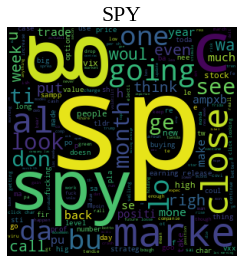

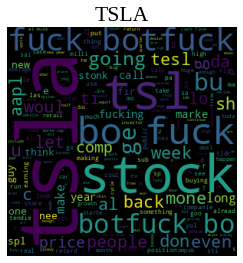

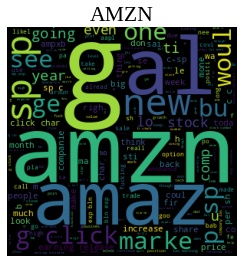

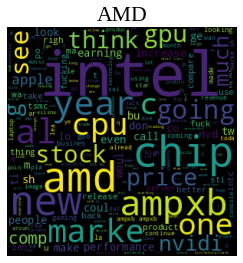

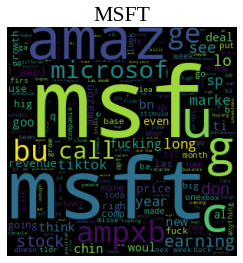

In [19]:
for i, stock in enumerate(chosen_stocks):
    plt.figure(figsize=(4, 4))
    wordcloud = wc.WordCloud(width=300, height=300).generate(" ".join(stocks[stock]))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(stock)
    plt.tight_layout()
    plt.show()

> 7. Comment on the results. Are these words to be expected? Is there anything that is surprising? 

The top terms are naturally all contained in the word clouds. What is most noticable is the number of mentions of the tickers. It is somewhat surprising, as one might expect more references like "the stock" after the first mention of the sticker. However, on the other hand, don't have much in the way of synonyms or words in the same category that relate to the stock or company. For instance, there are many words such as "week" or "year" that describe horizons on the stock market. Technical lingo, such as the afforementioned semiconductor terms, are often large and diverse, so any single term should be relatively rare.

## Part 3: Sentiment analysis

> _Exercise: Dictionary-based method to study sentiment on r/wallstreetbets_ 
>
>    1. Open the _wallstreetbets submissions dataframe_ we used in Week 6 (my version is [here](https://github.com/lalessan/comsocsci2021/blob/master/data/wallstreet_subs.csv.gz)).
>    2. Tokenize the _text_ of each submission (use the code you created in Week 6, exercise 3, point 2). Add it in a new column of your dataframe called "tokens".
>    3. Create one document per day in the dataset, containing all tokens for that day. Plot the length of the document (number of tokens) over time. Are documents long enough for using a dictionary-based method? 
>    4. Plot the average daily happiness on r/wallstreetbets using the function you created in step 3 (remember the video lesson in Week 2, for plotting nice time-series).
>    5. Compare happiness on _r/wallstreetbets_ to happiness on Twitter using the [hedonometer](http://hedonometer.org/timeseries/en_all/?from=2019-09-16&to=2021-03-15). What is (approximatively) the average value of the two time-series? How do you explain any difference between the two?
>    6. Download the daily Close price of the [S&P 500 Index](https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC) and plot it over time. This index measures the stock performance of 500 large companies listed on stock exchanges in the United States, you can read more about it in the [S&P 500 Wikipedia page](https://en.wikipedia.org/wiki/S%26P_500).
>    7. Compare the figures you created in steps 8. and 10. What do you observe? 
>    8. Discuss the limitations of your analysis. 

>    1. Open the _wallstreetbets submissions dataframe_ we used in Week 6 (my version is [here](https://github.com/lalessan/comsocsci2021/blob/master/data/wallstreet_subs.csv.gz)).
>    2. Tokenize the _text_ of each submission (use the code you created in Week 6, exercise 3, point 2). Add it in a new column of your dataframe called "tokens".

Both of these are performed in Part 2, and the dataframe `wsb_subs` is reused.

>    3. Create one document per day in the dataset, containing all tokens for that day. Plot the length of the document (number of tokens) over time. Are documents long enough for using a dictionary-based method?

In [20]:
daily_tokens_df = wsb_subs.set_index("created_utc").resample("1D").apply(list).reset_index()
daily_tokens_df["tokens"] = [[token for tokenlist in tokenlists for token in tokenlist] for tokenlists in daily_tokens_df["tokens"]]
daily_tokens_df["num_tokens"] = daily_tokens_df["tokens"].apply(len)

Share of documents with at least 10,000 tokens: 73.0245 %


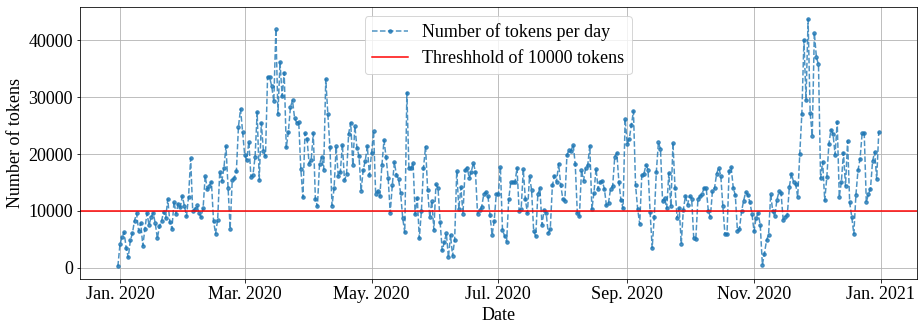

In [21]:
## Plot the length of the documents
fig, ax = plt.subplots(figsize=(15, 5))  # Create figure and plot data
ax.plot(daily_tokens_df.created_utc, daily_tokens_df['num_tokens'], ms=7, marker='.', ls='--', alpha=0.8, label='Number of tokens per day')
ax.axhline(y=10000, c='red', label='Threshhold of 10000 tokens')
myFmt = mdates.DateFormatter('%b. %Y')   # Change xaxis so it spells out the month
ax.xaxis.set_major_formatter(myFmt)
ax.set_ylabel('Number of tokens')
ax.set_title('Number of tokens per day')
plt.grid()
ax.legend()
print("Share of documents with at least 10,000 tokens: %.4f %%" %  (100 * (daily_tokens_df["num_tokens"] >= 10000).mean()))

About three quarters of documents contain at least 10,000 tokens - enough for dictionary-based sentiment analysis to be useful. While not optimal, the results should still be fairly accurate, especially at times of high activity, such as the stock market crash in March of 2020.

Some documents, however, contain only very few tokens. This is especially the case in the beginning, early June, and early November. This may cause the happiness scores calculated below to be highly variant for these periods.

>    4. Plot the average daily happiness on r/wallstreetbets using the function you created in step 3 (remember the video lesson in Week 2, for plotting nice time-series).

In [22]:
hedonometer = pd.read_csv('Hedonometer.csv')

# Function computing happiness score mean of given tokens
all_tokens = { token.lower(): happiness for token, happiness in zip(hedonometer["Word"], hedonometer["Happiness Score"]) }
def happiness(sent: list) -> float:
    """ Get happiness from a list of tokens """
    a = [all_tokens[t] for token in sent if (t := token.lower()) in all_tokens]
    return sum(a) / len(a)

daily_tokens_df['happiness_score'] = daily_tokens_df["tokens"].apply(happiness)

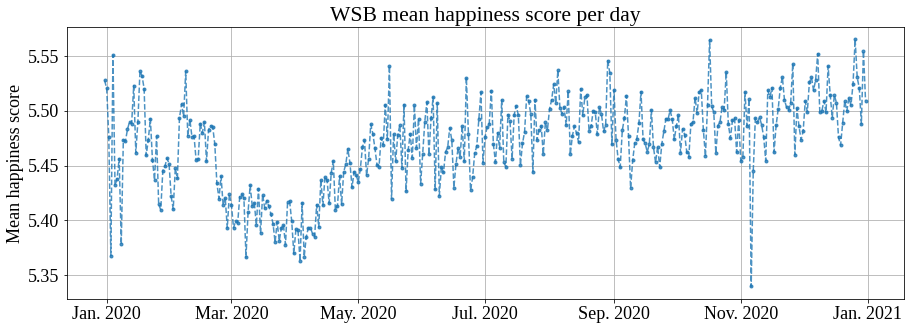

In [23]:
# Plot the average daily happiness
fig, ax = plt.subplots(figsize=(15, 5))               # Create figure and plot data
ax.plot(daily_tokens_df.created_utc, daily_tokens_df['happiness_score'], marker='.', ls='--', alpha=0.8)
myFmt = mdates.DateFormatter('%b. %Y')   # Change xaxis so it spells out the month
ax.xaxis.set_major_formatter(myFmt)
ax.set_ylabel('Mean happiness score')
ax.set_title('WSB mean happiness score per day')
plt.grid()

In the first week or two, the happiness scores are highly variant compared to the rest of the series. There is also a clear outlier in early November. These largely correspond to the days with very few tokens noted above. This highlights the need for a larger number of tokens when using dictionary-based happiness scores.

>    5. Compare happiness on _r/wallstreetbets_ to happiness on Twitter using the [hedonometer](http://hedonometer.org/timeseries/en_all/?from=2019-09-16&to=2021-03-15). What is (approximatively) the average value of the two time-series? How do you explain any difference between the two?

In [24]:
## Retrieving Hedonometer data
uri = 'http://hedonometer.org/api/v1/happiness/?format=json&timeseries__title=en_all&date__gte=2020-01-01&limit=367'
r = requests.get(uri)
hedonometer_df = pd.DataFrame(json.loads(r.content)['objects'])
hedonometer_df.happiness = hedonometer_df.happiness.astype(float)

In [25]:
## Print average of the two mean happiness series:
wsb_avg_happiness = np.mean(daily_tokens_df.happiness_score)
hedonometer_avg_happiness = np.mean(hedonometer_df.happiness)
print(f"Average happiness of wsb throughout 2020:     {wsb_avg_happiness:.4f}")
print(f"Average happiness of Twitter throughout 2020: {hedonometer_avg_happiness:.4f}\n")

## Print standard deviation of the two mean happiness series:
wsb_std_happiness = np.std(daily_tokens_df.happiness_score, ddof=1)
hedonometer_std_happiness = np.std(hedonometer_df.happiness, ddof=1)
print(f"Std happiness of wsb throughout 2020:     {wsb_std_happiness:.4f}")
print(f"Std happiness of Twitter throughout 2020: {hedonometer_std_happiness:.4f}")

Average happiness of wsb throughout 2020:     5.4701
Average happiness of Twitter throughout 2020: 5.9071

Std happiness of wsb throughout 2020:     0.0408
Std happiness of Twitter throughout 2020: 0.0680


Twitter has a statistically higher happiness score than r/wallstreetbets.

First off, the user bases are quite different and react to different things. Twitter is used by many different groups of people, and different events will dominate at different times, as is the case <a href="https://hedonometer.org/timeseries/en_all/?from=2019-09-16&to=2021-03-15">in June where a huge dip was attributed to the police brutality protests</a>.
It seems as if the WSB forum went unaffected by this, which makes sense as their focus area does change over time, and they will further tend to use the same language all the time, unless events specific to the stock market occur.

Another explanation may differences in the formats. Many Reddit submissions are relatively long compared to the limited number of characters available in a tweet. This may cause Twitter users to use their few available words on stronger ones, whereas the many less strong words on Reddit both reduce the variance and sensitivity and make the average more neutral.

>    6. Download the daily Close price of the [S&P 500 Index](https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC) and plot it over time. This index measures the stock performance of 500 large companies listed on stock exchanges in the United States, you can read more about it in the [S&P 500 Wikipedia page](https://en.wikipedia.org/wiki/S%26P_500).

No handles with labels found to put in legend.


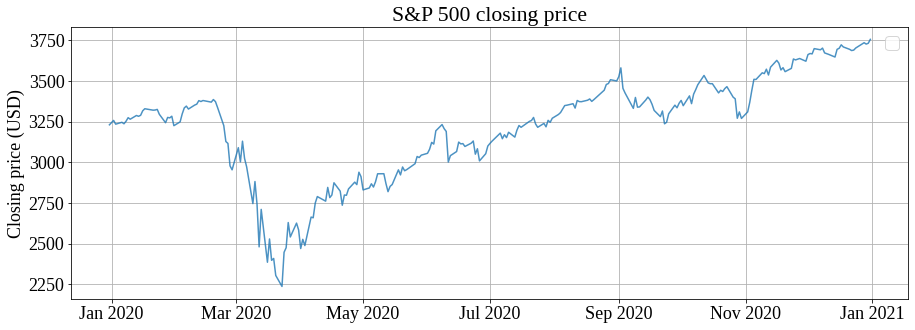

In [26]:
## Download the data
start = pd.to_datetime('2019-12-31')
end = pd.to_datetime('2020-12-31')

SP500 = pdr.get_data_yahoo('^GSPC', start, end)

## Plot the S&P 500 closing price over the same time period as wsb submissions
fig, ax = plt.subplots(figsize=(15, 5))               # Create figure and plot data
ax.plot(SP500.index, SP500['Close'], alpha=0.8)
myFmt = mdates.DateFormatter('%b. %Y')   # Change xaxis so it spells out the month
ax.xaxis.set_major_formatter(myFmt)
ax.set_ylabel('Closing price (USD)')
ax.set_title('S&P 500 closing price')
plt.grid()

>    7. Compare the figures you created in steps 8. and 10. What do you observe? 

The figures showing mean happiness scores for WSB and the close prices of S&P500 show a positive correlation, with a low point during the stock market crash in March and the following recovery. Uncertainty concerning the presidential election in early November is also easily observable in both figures.

This is not surprising, as the success of many r/wallstreetbets user is largely tied to the stock market.

>    8. Discuss the limitations of your analysis. 

The analysis has a number of limitations. One major is the rule based approach. While there is mostly enough data to fulfill the thumb rule of 10,000 tokens per document, the rule based happiness scores capture neither context nor jargons, of which there are many on r/wallstreetbets. For instance, the common phrase "ride this rocket to the moon", or 🚀🚀🚀🌑 as it is often expressed, is only mildly positive according to the used approach, but highly positive on r/wallstreetbets.

Emojis present another limitation: Emoji phrases such as 🦍🦍🦍 (apes together strong), 💎🤲 (diamond hands), and 🚀🚀🚀🌑 (rocket to the moon) are a large part of the lingo on r/wallstreetbets, but are not captured by the happiness dictionary.

The usage, especially in context, of certain words is also lost. Some words are used mostly differently from their most common uses with poor happiness scores to follow. Some examples are "retarded" and "shorts". "retarded" is a negative word with a happiness score of 2.62, but users often refer to themselves as retards in a positive light. Inversely, "shorts" is almost exclusively used to refer short sellers by the users unlike the more common meaning of short pants. Short sellers are reviled on r/wallstreetbets, so a happiness score of 5.92 is hardly a good measure.

All in all, these issues muddy the picture and may help to explain the relatively lower variances and neutral happiness scores.

## Part 4: Communities for the Zachary Karate Club Network

> _Exercise: The Zachary's karate club Network_: In this exercise, we will work on Zarachy's karate club graph (refer to the Introduction of Chapter 9). The dataset is available in NetworkX, by calling the function [karate_club_graph](https://networkx.org/documentation/stable//auto_examples/graph/plot_karate_club.html).
>
> 1. Visualize the graph using [netwulf](https://netwulf.readthedocs.io/en/latest/). Set the color of each node based on the club split (the information is stored as a node attribute). My version of the visualization is below.
>
> 2. Write a function to compute the __modularity__ of a graph partitioning (use **equation 9.12** in the book). The function should take a networkX Graph and a partitioning as inputs and return the modularity.
> 3. Explain in your own words the concept of _modularity_. 
> 4. Compute the modularity of the Karate club split partitioning using the function you just wrote. Note: the Karate club split partitioning is avilable as a [node attribute](https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.classes.function.get_node_attributes.html), called _"club"_.
> 5. We will now perform a small randomization experiment to assess if the modularity you just computed is statitically different from $0$. To do so, we will implement a [configuration model](https://en.wikipedia.org/wiki/Configuration_model). In short, we will create a new network, such that each node has exactly the same degree as in the original network, but different connections. Here is how the algorithm works.
>       * __a.__ Create an identical copy of your original network.
>       * __b.__ Consider the list of network edges. Create two lists: the list of source nodes and target nodes. 
>       * __c.__ Shuffle the list of target nodes. Create new edges that have as sources the original source nodes and as targets the shuffled target nodes. 
>       * __d.__ Remove all the original network edges from your network. Add all the new _shuffled_ edges you created in step __c.__.
> 6. Double check that your algorithm works well, by showing that the degree of nodes in the original network and in the the configuration model are the same.
> 7. Create $1000$ randomized version of the Karate Club network using the algorithm you wrote in step 5. For each of them, compute the modularity of the "club" split and store it in a list.
> 8. Compute the average and standard deviation of the modularity for the configuration model.
> 9. Plot the distribution of the configuration model modularity. Plot the actual modularity of the club split as a vertical line (use [axvline](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axvline.html)). 
> 10. Comment on the figure. Is the club split a good partitioning? Why do you think I asked you to compare with the configuration model? What is the reason why we preserved the nodes degree?
> 11.  Use [the Python Louvain-algorithm implementation](https://anaconda.org/auto/python-louvain) to find communities in this graph. Report the value of modularity found by the algorithm. Is it higher or lower than what you found above for the club split? What does this comparison reveal?
> 12.  Compare the communities found by the Louvain algorithm with the club split partitioning by creating a matrix **_D_** with dimension (2 times _A_), where _A_ is the number of communities found by Louvain. We set entry _D_(_i_,_j_) to be the number of nodes that community _i_ has in common with group split _j_. The matrix **_D_** is what we call a [**confusion matrix**](https://en.wikipedia.org/wiki/Confusion_matrix). Use the confusion matrix to explain how well the communities you've detected correspond to the club split partitioning.

> 1. Visualize the graph using [netwulf](https://netwulf.readthedocs.io/en/latest/). Set the color of each node based on the club split (the information is stored as a node attribute). My version of the visualization is below.

In [27]:
G = nx.karate_club_graph()
for i in G:
    if G.nodes[i]["club"] == "Mr. Hi":
        G.nodes[i]["color"] = "blue"
    else:
        G.nodes[i]["color"] = "green"

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 58936)
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/http/server.py", line 711, in send_head
    f = open(path, 'rb')
FileNotFoundError: [Errno 2] No such file or directory: '/home/asger/.netwulf/favicon.ico'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/local/lib/python3.9/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/local/lib/python3.9/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/local/lib/python3.9/http/server.py", line 653, in __init__
    super().__init__(*args, **kwargs)
  File "/usr/local/lib/python3.9/sockets

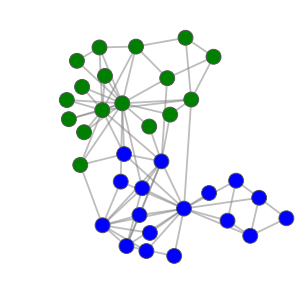

In [28]:
nw.visualize(G)
print()

Nodes belonging to Mr. Hi are in blue, and nodes belonging to Officer are in green.

> 2. Write a function to compute the __modularity__ of a graph partitioning (use **equation 9.12** in the book). The function should take a networkX Graph and a partitioning as inputs and return the modularity.

In [29]:
def modularity(graph: nx.Graph, *ns) -> float:
    """ ns are lists of nodes for each partition of the graph """
    nc = len(ns)
    s = 0
    for n in ns:
        subgraph = graph.subgraph(n)
        Lc = len(subgraph.edges)
        L = len(graph.edges)
        kc = sum(d for _, d in graph.degree(subgraph.nodes))
        s += Lc / L - (kc / (2 * L)) ** 2  # Eq. 9.12
    return s

> 3. Explain in your own words the concept of _modularity_. 

Modularity is loosely speaking a measure of how good a given partitioning of a graph is. Higher modularity implies a better partitioning. It measures how much edge densities in each partition vary from the global edge density. In random networks, no such systematic differences exist, and the modularity should be expected to be distributed with a mean of 0. This provides a way to determine if a given partitioning is a result of chance or not. A higher modularity implies a better partitioning of the graph.

> 4. Compute the modularity of the Karate club split partitioning using the function you just wrote. Note: the Karate club split partitioning is avilable as a [node attribute](https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.classes.function.get_node_attributes.html), called _"club"_.

In [30]:
n1 = [i for i in G if G.nodes[i]["club"] == "Mr. Hi"]  # Nodes belonging to Mr. Hi
n2 = [i for i in G if G.nodes[i]["club"] != "Mr. Hi"]  # Nodes not beloning to Mr. Hi
print("Modularity of club split: %.4f" % modularity(G, n1, n2))

Modularity of club split: 0.3582


> 5. We will now perform a small randomization experiment to assess if the modularity you just computed is statitically different from $0$. To do so, we will implement a [configuration model](https://en.wikipedia.org/wiki/Configuration_model). In short, we will create a new network, such that each node has exactly the same degree as in the original network, but different connections. Here is how the algorithm works.
>       * __a.__ Create an identical copy of your original network.
>       * __b.__ Consider the list of network edges. Create two lists: the list of source nodes and target nodes. 
>       * __c.__ Shuffle the list of target nodes. Create new edges that have as sources the original source nodes and as targets the shuffled target nodes. 
>       * __d.__ Remove all the original network edges from your network. Add all the new _shuffled_ edges you created in step __c.__.

In [31]:
def conf_model(G: nx.Graph) -> nx.MultiGraph:
    # a
    g = nx.MultiGraph()
    g.add_nodes_from(G.nodes)
    g.add_edges_from(G.edges)
    # b
    sources, targets = np.transpose(G.edges)
    # c
    np.random.shuffle(targets)
    edges = [(source, target) for source, target in np.transpose([sources, targets])]
    # d
    g.remove_edges_from(G.edges)
    g.add_edges_from(edges)

    return g

> 6. Double check that your algorithm works well, by showing that the degree of nodes in the original network and in the the configuration model are the same.

In [32]:
random_G = conf_model(G)
print("Number of degrees in original network: %i" % sum(d for _, d in G.degree))
print("Number of degrees in random network:   %i" % sum(d for _, d in random_G.degree))

Number of degrees in original network: 156
Number of degrees in random network:   156


> 7. Create $1000$ randomized version of the Karate Club network using the algorithm you wrote in step 5. For each of them, compute the modularity of the "club" split and store it in a list.

In [33]:
m = [modularity(conf_model(G), n1, n2) for _ in range(1000)]

> 8. Compute the average and standard deviation of the modularity for the configuration model.

In [34]:
print("Average modularity: %.4f" % np.mean(m))
print("Standard deviation: %.4f" % np.std(m, ddof=1))

Average modularity: -0.0103
Standard deviation: 0.0559


> 9. Plot the distribution of the configuration model modularity. Plot the actual modularity of the club split as a vertical line (use [axvline](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axvline.html)). 

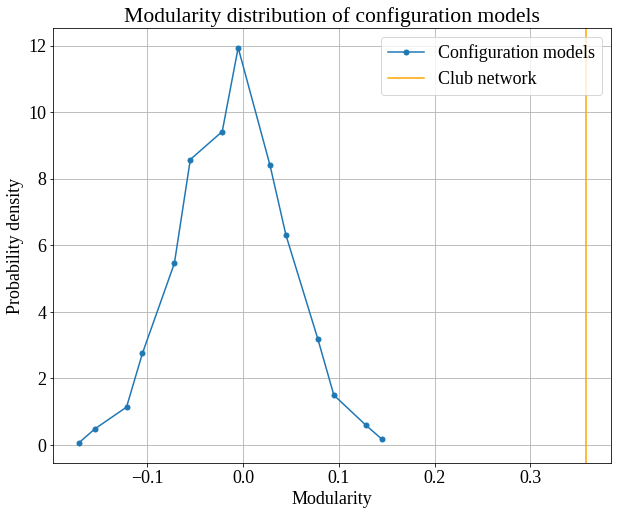

In [35]:
## Use binning function from Part 1
mod, dens = bins(m, lambda x, b: np.linspace(min(x), max(x), b), bins=20)
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(mod, dens, marker=".", ms=10, label="Configuration models")
ax.axvline(modularity(G, n1, n2), c="orange", label="Club network")
ax.grid(True)
ax.set_title("Modularity distribution of configuration models")
ax.set_xlabel("Modularity")
ax.set_ylabel("Probability density")
ax.legend()

> 10. Comment on the figure. Is the club split a good partitioning? Why do you think I asked you to compare with the configuration model? What is the reason why we preserved the nodes degree?

The configuration models' modularities are normally distributed around 0 with a slight left skew. The club split is clearly several standard deviations from the mean. It is therefore clear that the club split is not any random split, but instead a good partitioning. Preserving the nodes' degrees allows for an apples-to-apples comparison between the configuration models and the club split.

> 11.  Use [the Python Louvain-algorithm implementation](https://anaconda.org/auto/python-louvain) to find communities in this graph. Report the value of modularity found by the algorithm. Is it higher or lower than what you found above for the club split? What does this comparison reveal?

In [36]:
partition = cm.best_partition(G)
nc = max(partition.values()) + 1
ns = [[] for i in range(nc)]
for i, p in partition.items():
    ns[p].append(i)
print("Modularity according to Louvain algorithm: %.4f" % modularity(G, *ns))
print("Number of partitions: %i" % nc)

Modularity according to Louvain algorithm: 0.4188
Number of partitions: 4


The Louvain algorithm found a higher modularity than the club split. This shows that it is possible to divide the graph into components that are even stronger internally connected than the club split according to the modularity measure.

> 12.  Compare the communities found by the Louvain algorithm with the club split partitioning by creating a matrix **_D_** with dimension (2 times _A_), where _A_ is the number of communities found by Louvain. We set entry _D_(_i_,_j_) to be the number of nodes that community _i_ has in common with group split _j_. The matrix **_D_** is what we call a [**confusion matrix**](https://en.wikipedia.org/wiki/Confusion_matrix). Use the confusion matrix to explain how well the communities you've detected correspond to the club split partitioning.

In [37]:
D = np.zeros((2, nc), dtype=int)
for i, club in enumerate((n1, n2)):
    for j, n in enumerate(ns):
        D[i, j] = len(set.intersection(set(club), set(n)))
t = Table()
t.add_header(["", *("P. %i" % i for i in range(1, 5))])
t.add_row(["Mr. Hi", *D[0]], left_align=[True, *[False]*len(D[0])])
t.add_row(["Officer", *D[1]], left_align=[True, *[False]*len(D[0])])
print(t)

        | P. 1 | P. 2 | P. 3 | P. 4
--------+------+------+------+-----
Mr. Hi  |    1 |   11 |    0 |    5
Officer |   10 |    1 |    6 |    0


The Louvain algorithm largely found the same partitions as the club splits. In fact, it has, with only two exceptions, found the same partitions, but subdivided each club into two subdivisions each. This is revealed by the union of partition 2 and 4 almost being equal Mr. Hi, and the union of partition 1 and 3 almost being equal to Officer.